In [2]:
from utilities import load_mquad
import numpy as np
from SNP_VAE_modified import *
import argparse

In [12]:
base_path = "/home/linxy29/data/maester/maester_paper/k562_bt142/maester/trimmed_starsolo_chrM_cellSNP0_WaldVariant_paperCell"
#base_path = "/Users/linxy29/Documents/Data/maester/maester_paper/k562_bt142/variant_selection/mixed_effect/supervised_glm_Wald"
SNP_VAE_res = base_path + "SNP_VAE_results/"
label_path = "/home/linxy29/data/maester/maester_paper/k562_bt142/cell_label.csv"

The number of variants:  3972
Start loading raw data.
Finish loading raw data.
Start filtering low-quality cells and SNPs.


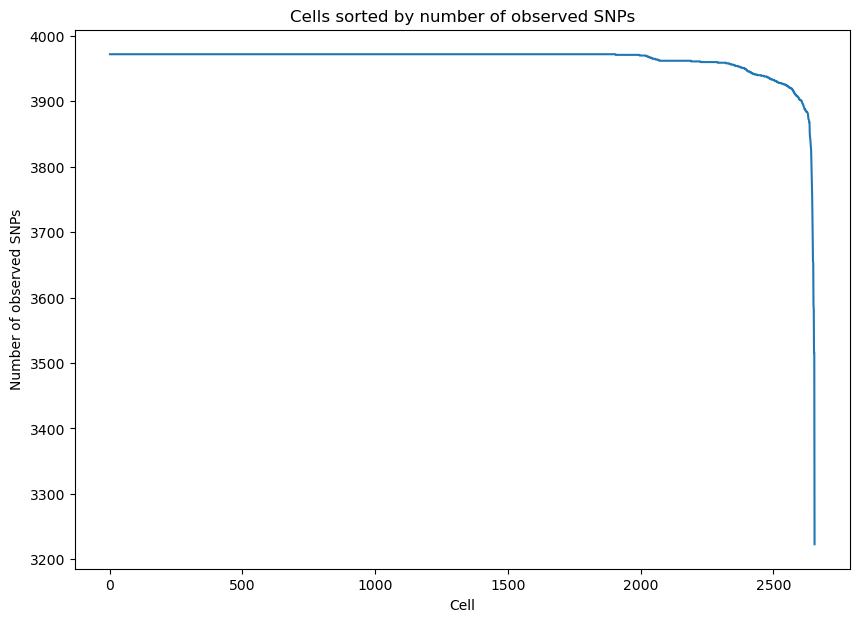

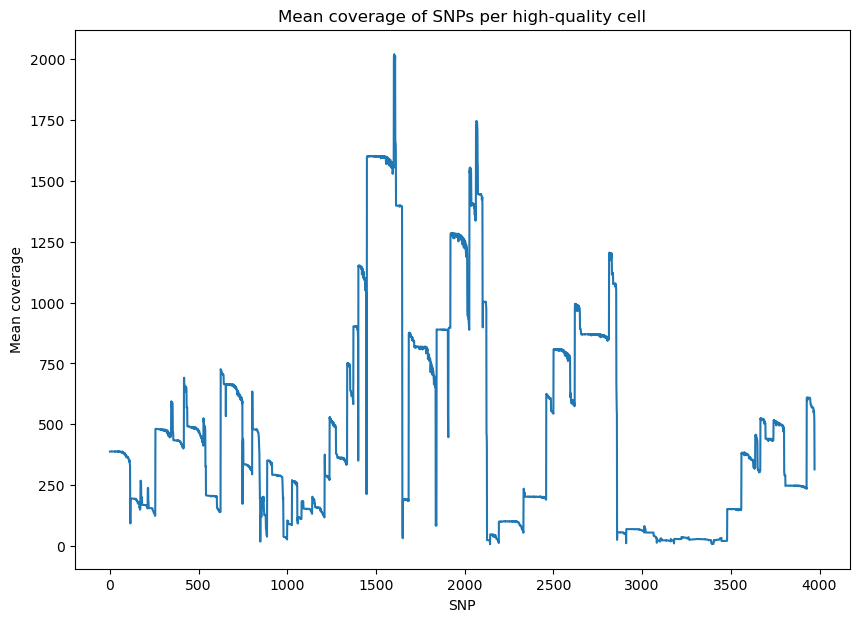

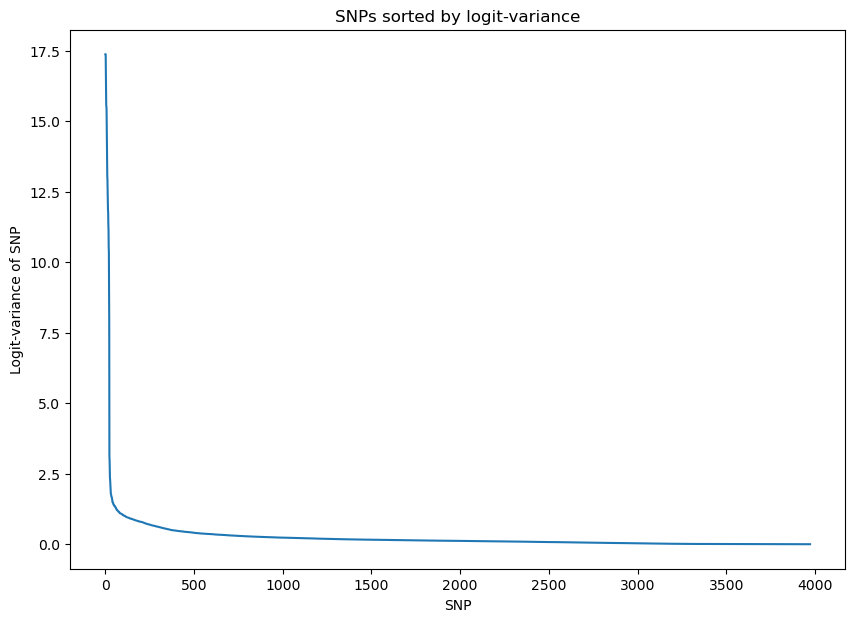

Finish filtering low-quality data, 2655 cells and 3961 SNPs will be used for downstream analysis.
Start training VAE.
Epoch[1/1000], Cost: 107.906151
Epoch[2/1000], Cost: 49.292255
Epoch[3/1000], Cost: 47.657017
Epoch[4/1000], Cost: 45.153831
Epoch[5/1000], Cost: 42.327892
Epoch[6/1000], Cost: 40.390022
Epoch[7/1000], Cost: 38.823299
Epoch[8/1000], Cost: 37.838100
Epoch[9/1000], Cost: 37.163849
Epoch[10/1000], Cost: 36.716301
Epoch[11/1000], Cost: 36.397083
Epoch[12/1000], Cost: 36.178085
Epoch[13/1000], Cost: 36.023888
Epoch[14/1000], Cost: 35.912807
Epoch[15/1000], Cost: 35.830284
Epoch[16/1000], Cost: 35.764214
Epoch[17/1000], Cost: 35.710728
Epoch[18/1000], Cost: 35.667015
Epoch[19/1000], Cost: 35.629513
Epoch[20/1000], Cost: 35.597385
Epoch[21/1000], Cost: 35.569035
Epoch[22/1000], Cost: 35.543800
Epoch[23/1000], Cost: 35.520985
Epoch[24/1000], Cost: 35.500061
Epoch[25/1000], Cost: 35.480740
Epoch[26/1000], Cost: 35.462769
Epoch[27/1000], Cost: 35.445995
Epoch[28/1000], Cost: 35.4

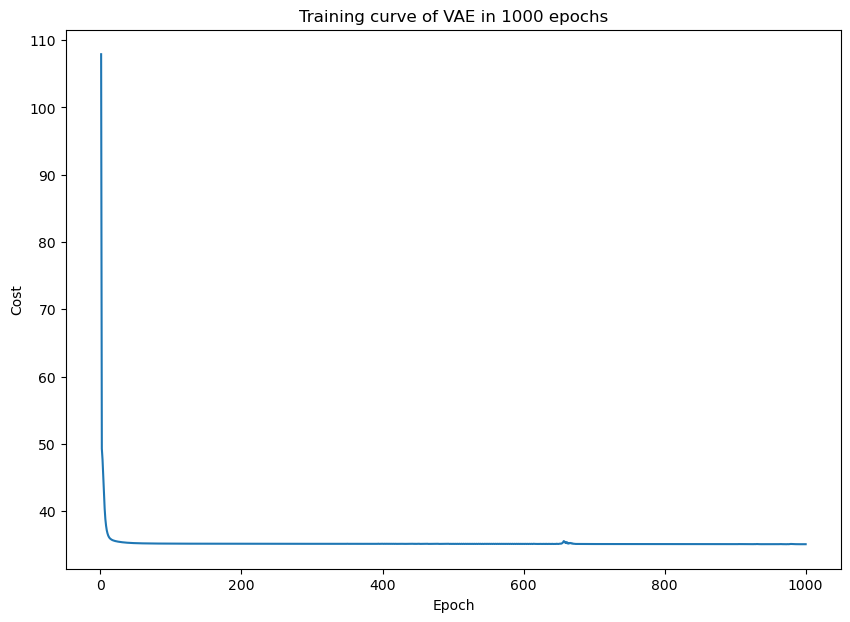

Start learning PCA and UMAP of latent space in VAE.
Finish learning, PCA and UMAP of latent space will be shown below.


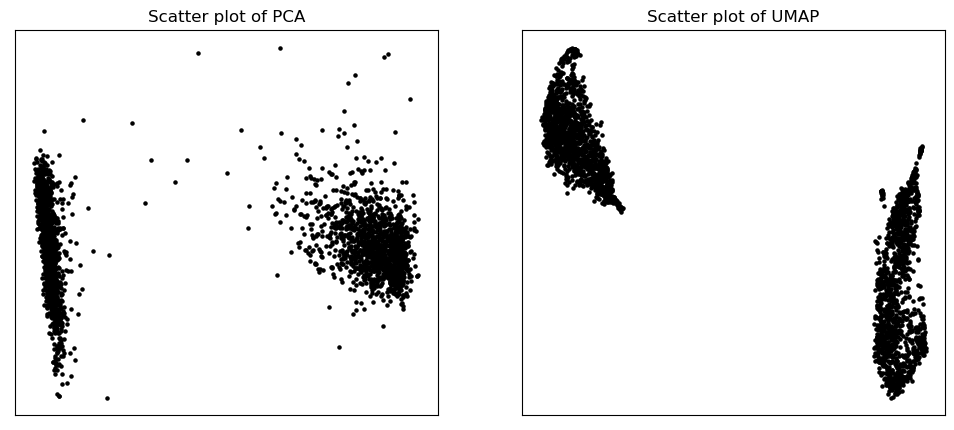

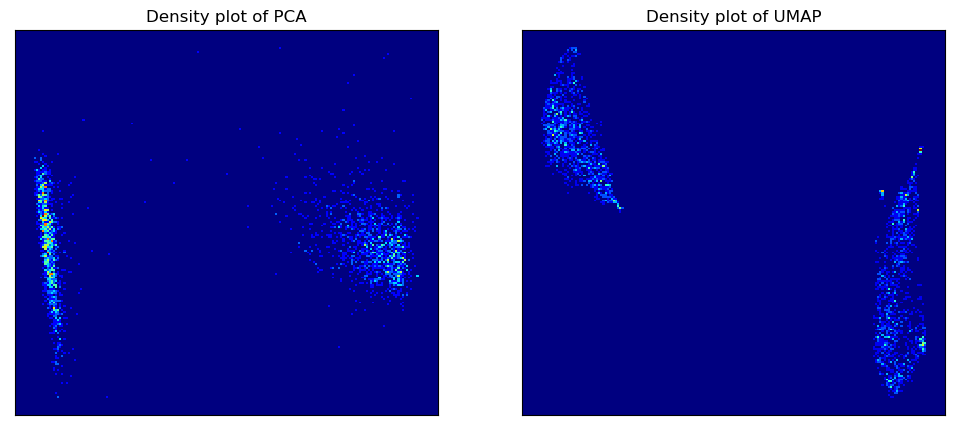

Start clustering.
2 clusters, Distortion: 4570.788086
3 clusters, Distortion: 3048.791016
4 clusters, Distortion: 2714.156494
Finish clustering, PCA, UMAP, distortion, silhouette score of K-means clustering will be shown below.


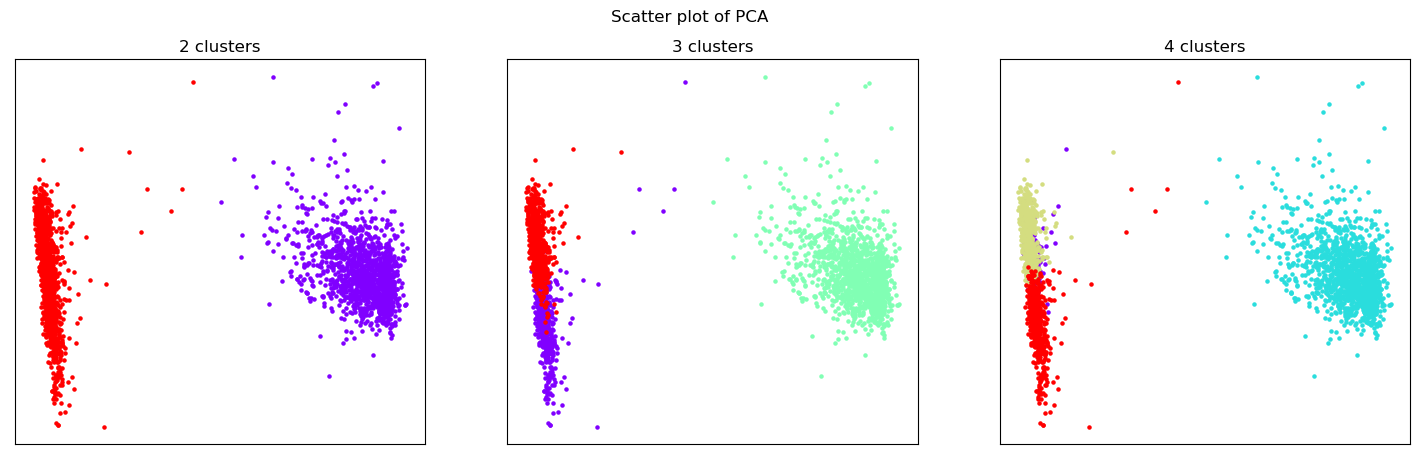

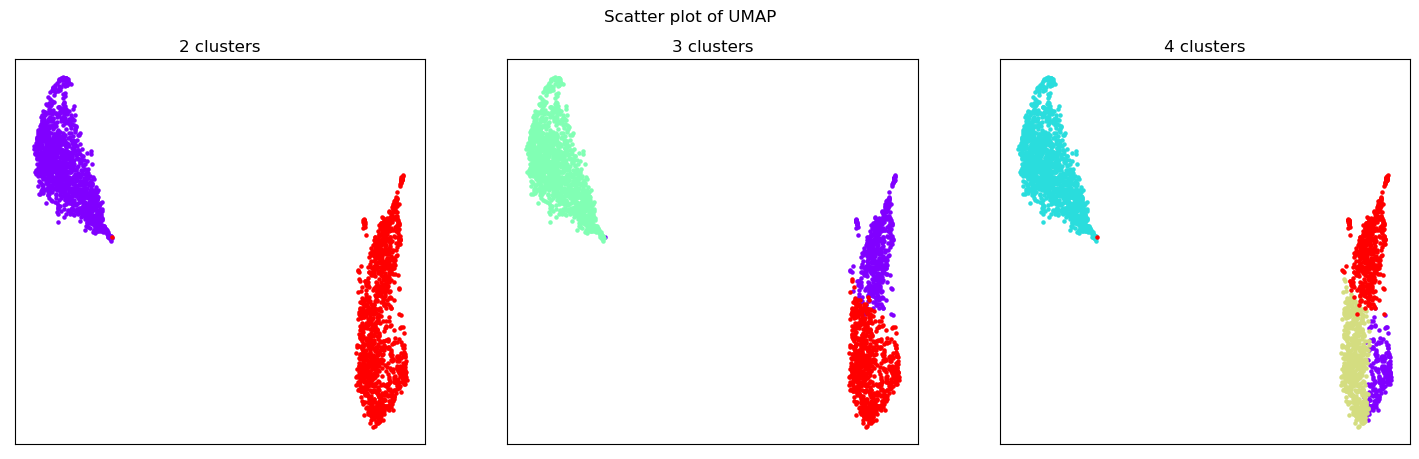

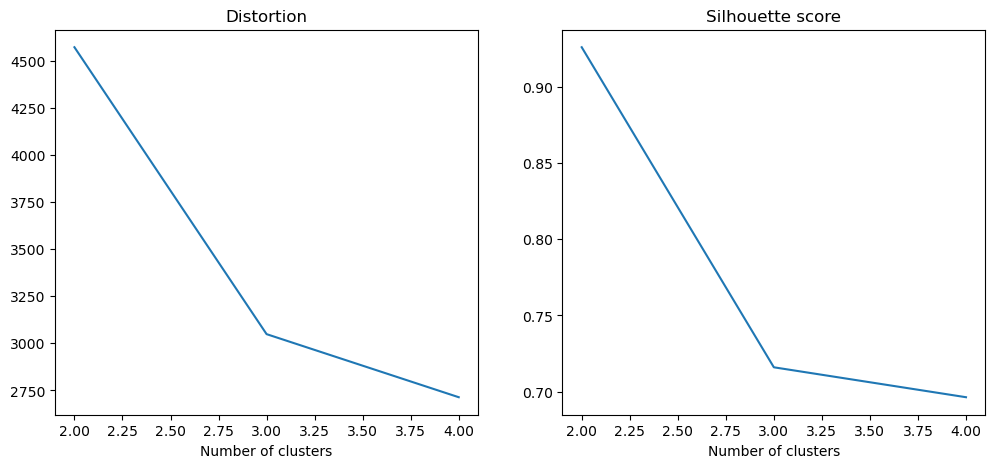

In [13]:
## detect SNP_VAE_res 
if not os.path.exists(SNP_VAE_res):
    os.makedirs(SNP_VAE_res)

## read data
AD, DP, mtSNP_ids = load_mquad(base_path, "", "")

#exec(open("/home/linxy29/code/Ho_maester/SNP_VAE_modified.py").read())
#exec(open("/Users/linxy29/Documents/Code/Ho_maester/SNP_VAE_modified.py").read())
test1 = SNP_VAE(AD = AD.T, DP = DP.T, variant_name = mtSNP_ids, SNPread = "unnormalized") # output path of cellSNP-lite
test1.filtering(cell_SNPread_threshold = 0, SNP_DPmean_threshold = 0, SNP_logit_var_threshold = 0, figure_path = SNP_VAE_res)
test1.training()
test1.clustering(max_cluster = 4) # maximum number for k-means clustering


In [15]:
## get label and barcode
barcode_file = base_path + "/passed_sample_names.txt"
### read barcode
barcode = np.genfromtxt(barcode_file, dtype=str)[test1.cell_filter]
print(len(barcode))
### convert cell label to vector
df = test1.labels
### convert to dataframe
df = pd.DataFrame(df).T
### add 'label' in front of column names
df.columns = ['label_' + str(x) for x in df.columns]
### make dataframe with barcode and cell label
df['barcode'] = barcode

2655


In [16]:
## add embedding coordinates
### add PCA coordinates
df['PCA_1'] = test1.pc.T[0]
df['PCA_2'] = test1.pc.T[1]
### add UMAP coordinates
df['UMAP_1'] = test1.embedding_2d.T[0]
df['UMAP_2'] = test1.embedding_2d.T[1]

In [17]:
## add true label
### get true label
true_label_path = label_path
true_label_df = pd.read_csv(true_label_path)
df = df.merge(true_label_df, left_on='barcode', right_on='barcode')

## save dataframe as csv
df.to_csv(SNP_VAE_res + '/SNP_VAE_results.csv', index=True)
## save test1 object
import pickle
with open(SNP_VAE_res + '/SNP_VAE_object.pkl', 'wb') as f:
    pickle.dump(test1, f)

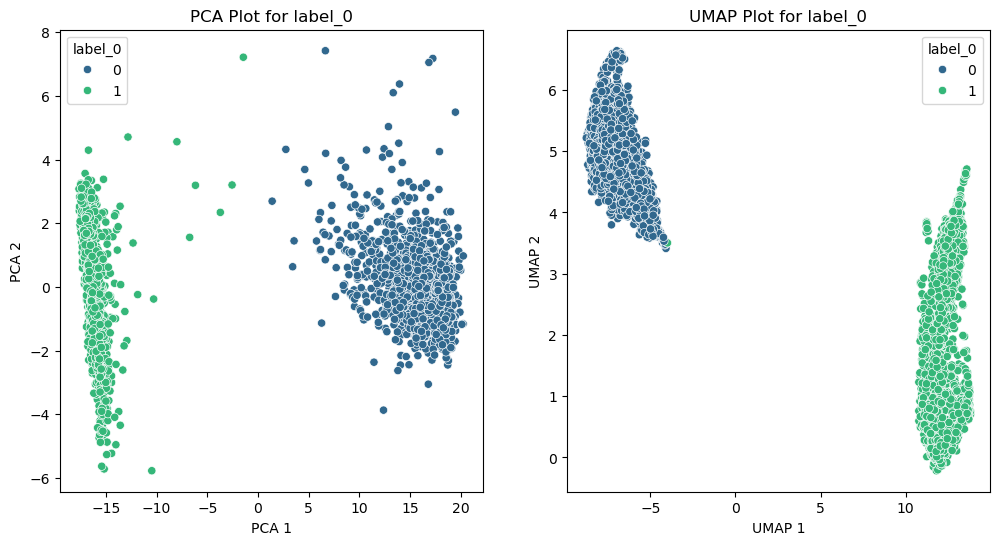

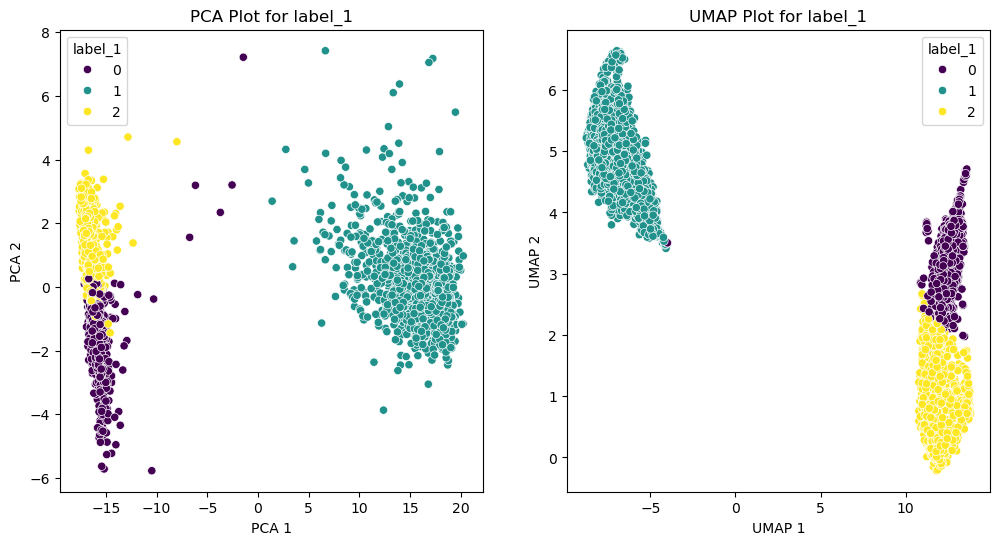

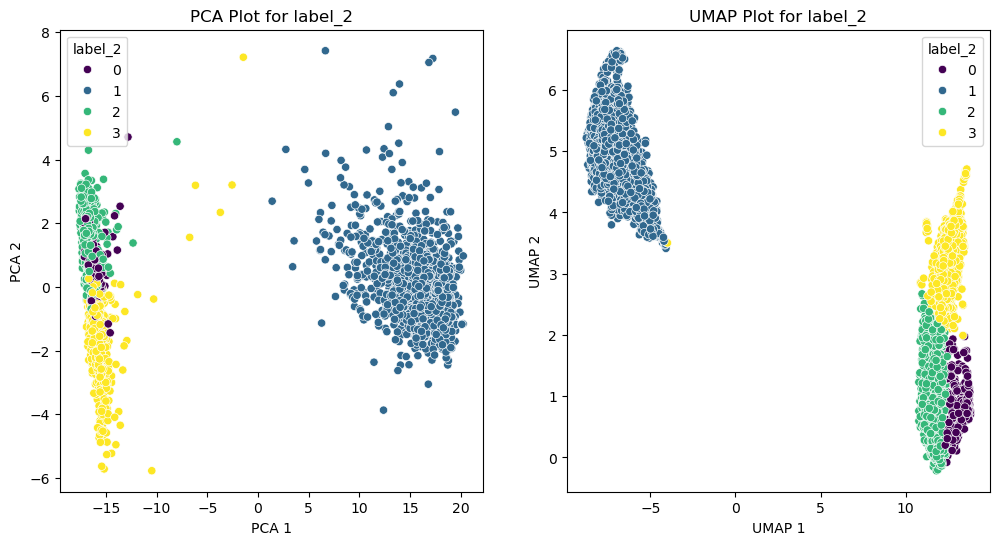

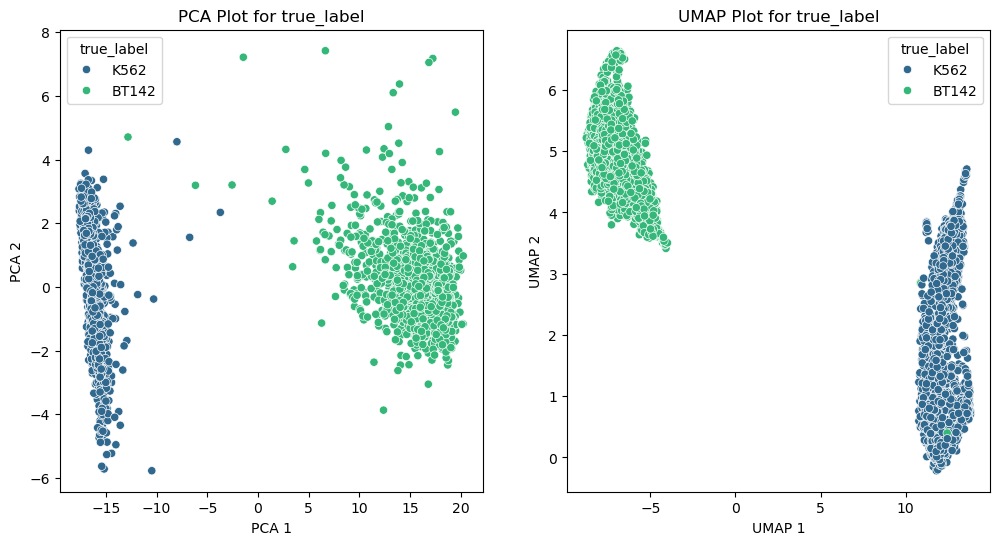

In [18]:
## save the embedding plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Identify label columns
label_columns = [col for col in df.columns if 'label' in col]

### Iterate through label columns and create plots
for label_col in label_columns:
    plt.figure(figsize=(12, 6))

    # First subplot for PCA
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='PCA_1', y='PCA_2', hue=label_col, data=df, palette='viridis')
    plt.title(f'PCA Plot for {label_col}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    # Second subplot for UMAP
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue=label_col, data=df, palette='viridis')
    plt.title(f'UMAP Plot for {label_col}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    # Save the plot
    plt.savefig(SNP_VAE_res + f'/{label_col}_embedding.png')

    # Show the plot
    plt.show()